# Altimetry Data

(specifically, ICESat-2)

> This page is a Jupyter Notebook that can be [found and downloaded at the GitHub repository](https://github.com/trchudley/geospatial-python-durham/blob/main/website/03_data/04_altimetry.ipynb).

Once again, there is no convenient STAC interface for altimetry data. The alternative is nearly as good though - the [SlideRule tool](https://github.com/SlideRuleEarth) has been developed for ICESat-2 (and GEDI) data, which allows you to generate ICESat-2 processed data on the fly. 

In [1]:
import pdemtools as pdt 
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from sliderule import sliderule, icesat2
from shapely.geometry import box

## SlideRule Example

Let's examine another part of Greenland, and download a bit of the ArcticDEM mosaic for comparison.

In [2]:
russell_bounds = [-231000,-2509000,-214000,-2498000]

russell_gdf_3413 = gpd.GeoDataFrame(geometry=[box(*russell_bounds)], crs=3413)
russell_gdf_4326 = russell_gdf_3413.to_crs(4326)

dem = pdt.load.mosaic('arcticdem', 32, bounds=russell_bounds)
hillshade = dem.pdt.terrain('hillshade')

Text(0.5, 1.0, 'ArcticDEM Mosaic of Russell Glacier')

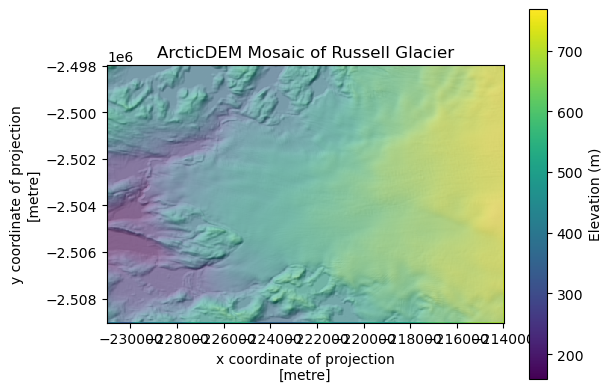

In [3]:
fig, ax = plt.subplots()

dem.plot.imshow(ax=ax, cbar_kwargs={'label': 'Elevation (m)'})
hillshade.plot.imshow(ax=ax, alpha=0.5, cmap='gray', add_colorbar=False)
ax.set_aspect('equal')
ax.set_title('ArcticDEM Mosaic of Russell Glacier')

Now, let's show a quick example of how to download ICESat-2 ATL06 data from SlideRule.

In [6]:
# connect to sliderule
icesat2.init("slideruleearth.io")

# Turn the geodataframe into a sliderule-friendly object
sr_region = sliderule.toregion(russell_gdf_4326)

# set search parameters (apart from dates)
params = {
    "poly": sr_region["poly"],
    "t0": "2020-01-01",  # Start date
    "t1": "2020-12-31",  # End date
    "srt": 3,    # Surface. 0-land, 1-ocean, 2-seaice, 3-landice (default), 4-inlandwater
    "cnf": 1,    # Confidence. Default 1 (within 10 m). 2: Low. 3: Medium. 4: High.
    "ats": 20,   # Mininum along track spread. SR Default: 20.
    "cnt": 10,   # Minimum photon count in segment. Default 10.
    "len": 40,   # Extent length. ATL06 default is 40 metres.
    "res": 20,   # Step distance. ATL06 default is 20 metres.
    "track": 0,  # Integer: 0: all tracks, 1: gt1, 2: gt2, 3: gt3. Default 0.
    "sigma_r_max": 5,  # Max robust dispersion [m]. Default 5.
}

is2_gdf = icesat2.atl06p(params).to_crs(3413)

n_points = len(is2_gdf)
print(f"Number of points found: {n_points}")

Warning, this environment is using an outdated client (v4.9.1). The code will run but some functionality supported by the server (v4.19.0) may not be available.


Number of points found: 18537


Now we have our ICESat-2 ATL06 data as a nice geodataframe:

In [7]:
is2_gdf.head()

h_sigma  rgt      h_mean  \
time                                                       
2020-01-10 09:35:06.322201600  0.039076  224  731.273062   
2020-01-10 09:35:06.325011200  0.057742  224  732.417008   
2020-01-10 09:35:06.327821824  0.048733  224  732.887001   
2020-01-10 09:35:06.330632960  0.025287  224  733.142206   
2020-01-10 09:35:06.333442816  0.035668  224  733.993594   

                               w_surface_window_final      y_atc  \
time                                                               
2020-01-10 09:35:06.322201600                3.000000  71.362442   
2020-01-10 09:35:06.325011200                3.881913  71.392601   
2020-01-10 09:35:06.327821824                3.435776  71.412392   
2020-01-10 09:35:06.330632960                3.000000  71.422310   
2020-01-10 09:35:06.333442816                3.000000  71.423027   

                               n_fit_photons  dh_fit_dx  gt  spot  region  \
time                                                                        
2020-01-10 09:35:06.322201600            118   0.046058  30     4       5   
2020-01-10 09:35:06.325011200            121   0.055053  30     4       5   
2020-01-10 09:35:06.327821824            131  -0.016056  30     4       5   
2020-01-10 09:35:06.330632960            135   0.048296  30     4       5   
2020-01-10 09:35:06.333442816            105   0.034484  30     4       5   

                               rms_misfit       x_atc  pflags  cycle  \
time                                                                   
2020-01-10 09:35:06.322201600    0.423777  12583511.0       0      6   
2020-01-10 09:35:06.325011200    0.634964  12583531.0       0      6   
2020-01-10 09:35:06.327821824    0.547110  12583551.0       0      6   
2020-01-10 09:35:06.330632960    0.293369  12583571.0       0      6   
2020-01-10 09:35:06.333442816    0.363403  12583592.0       0      6   

                               segment_id                          geometry  
time                                                                         
2020-01-10 09:35:06.322201600      628250  POINT (-214005.561 -2498259.909)  
2020-01-10 09:35:06.325011200      628251  POINT (-214009.553 -2498279.699)  
2020-01-10 09:35:06.327821824      628252  POINT (-214013.559 -2498299.504)  
2020-01-10 09:35:06.330632960      628253  POINT (-214017.574 -2498319.306)  
2020-01-10 09:35:06.333442816      628254  POINT (-214021.598 -2498339.107)

Let's plot the data to the same colour scale as the ArcticDEM:

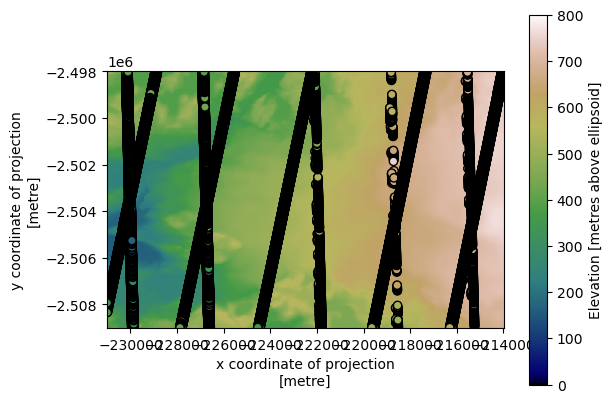

In [12]:
fix, ax = plt.subplots()

dem.plot.imshow(ax=ax, cmap='gist_earth', vmin=0, vmax=800, cbar_kwargs={'label': 'Elevation [metres above ellipsoid]'})
is2_gdf.plot(ax=ax, column='h_mean', cmap='gist_earth', vmin=0, vmax=800, ec='k', legend=False)
ax.set_title(None)

plt.show()

Great! Using the geodataframe, you may wish to perform tasks such as filtering to specific dates and crossover points. SlideRule also enables you to download other ICESat-2 derivative data.